# Creative machine learning - Advanced neural networks

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. An introduction to [convolutions](#convolution) and how they can be used in CNN
2. Defining a [convolutional Neural Network](#cnn) in Pytorch for image classification 
3. Coding our own [convolutional layer](#layer)
4. An explanation on [recurrent networks](#rnn) in practice
5. An exercise on [symbolic music generation](#music) with LSTM in both Pytorch and JAX

As usual, we are going to use relatively _low-level_ libraries to perform the first exercises (implementing convolutions). To observe this idea in simple setups, we are going to use the `numpy` library and also initialize the homemade course library `cml` and style for future plotting and exercise. We also set the random generator to a fixed point with `rng = np.random.RandomState(1)`, to ensure reproducibility

In [1]:
# Base imports
import time
import numpy as np
import matplotlib.pyplot as plt
from cml.plot import initialize_bokeh
from cml.panel import initialize_panel
from jupyterthemes.stylefx import set_nb_theme
from bokeh.io import show
initialize_bokeh()
initialize_panel()
set_nb_theme("onedork")
rng = np.random.RandomState(1)

Loading BokehJS ...

<a id="convolution"></a>
## Convolutions

In purely mathematical terms, convolution is a function derived from two given functions by integration which expresses how the shape of one is modified by the other. In simpler (discrete) terms, the convolution product of a matrix by a smaller one can be seen as _filtering_ the large matrix. Hence we slide the small matrix over the large one and compute local products at each position. Therefore the convolution operator $\star$ computes at each position $n$

$$
(f \star g)[n]=\sum _{m=-M}^{M}f[n-m]g[m].
$$

An example of this operation is shown here

<center>
<img src="images/02_convolution.png" align="center"/>
</center>

This operation can be used to _filter_ the image (as in the _gaussian blur_ operator), or _detect_ features (such as edges). 

Given a 32x32 image with RGB channels, we can represent it as a tensor of shape `(3, 32, 32)` which is (channels, height, width). When we perform convolution, we need a filter that has the same channel depth as the image. For example, we can use a 5x5 filter which is of shape `(3, 5, 5)` and slide it across the image left to right, top to bottom with a stride of 1 to perform convolution. We are going to perform this in numpy, depending on a certain amount of parameters, which define the behavior of our convolution

* `height` and `width`: spatial extend of the filters
* `stride`: stride size (number of steps to jump to the next position)
* `padding`: amount of padding (adding zeros in the original matrix)

Here note that we define a simple _horizontal line detector_ kernel, but we will display other kernels that you can toy off with later on 

In [2]:
# Properties of our kernel
pad = 2
stride = 1
height, width = 3, 3
# Our convolution kernel
weight = [
[1, 2, 1],
[0, 0, 0],
[-1, -2, -1],
]
weight = np.array(weight)
# Final kernel (replicated over channels)
kernel = np.repeat(weight[np.newaxis, :], 3, axis=1)

Next up we need to import some image on which to apply our convolution operation. Here, we display a small code to retrieve an image directly from a URL. You can replace the desired image by the URL of your choosing.

In [3]:
from PIL import Image
import requests
from io import BytesIO
from cml.plot import image, center_plot, cml_figure
# URL to load our example image from
url = "https://thumbnailer.mixcloud.com/unsafe/300x300/extaudio/6/b/a/b/d576-35c3-48a9-a01e-7dc4f0255e62.jpg"
response = requests.get(url)
img = np.array(Image.open(BytesIO(response.content)))
img = img.transpose(2, 0, 1)[:, :]
plot = center_plot(image(img, title="Example image"))
plot

Row
    [0] HSpacer()
    [1] Bokeh(Figure)
    [2] HSpacer()

In [4]:
x_w, x_h = img.shape[1], img.shape[2]
# Padding the original image
x_pad = np.pad(img, pad_width=((0, 0,), (pad, pad), (pad, pad)), mode='constant', constant_values=0)
# We can expect the output size to be
h_out = int(1 + (x_h + 2 * pad - height) / stride)
w_out = int(1 + (x_w + 2 * pad - width) / stride)
# So we will store our result in
y = np.zeros((1, h_out, w_out))

Computing the convolution itself can be performed by using the following loop (which amounts to _slide_ our kernel across the large matrix). As we have seen in the course, it corresponds to computing the convolution equation

$$
(f \star g)[n]=\sum _{m=-M}^{M}f[n-m]g[m].
$$


In [5]:
# Sliding the kernel across the matrix
for h in range(h_out):
    for w in range(w_out):
        i, j = h * stride, w * stride
        conv_sum = np.sum(x_pad[:, i:i+height, j:j+width] * weight)
        y[0, h, w] = conv_sum

We can witness the effect of this operation with the following plot

In [6]:
from bokeh.layouts import row
plot = center_plot(row(image(img, title="Input"), image(y, title="Convolved")))
plot

Row
    [0] HSpacer()
    [1] Bokeh(Row)
    [2] HSpacer()

As we discussed previously, depending on the content (weights) of the kernel, different features are detected by different types of convolutional kernels, we outline here several kernels that you can play with (or even try your own) by modifying the previous code.

In [7]:
# Gaussian blur
weight = [
[1, 1, 1],
[1, 3, 1],
[1, 1, 1],
]
# Sharpen
weight = [
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0],
]
# Outline
weight = [
[-1, -1, -1],
[-1, 8, -1],
[-1, -1, -1],
]
# Detect vertical lines
weight = [
[-1, 0, 1],
[-2, 0, 2],
[-1, 0, 1],
]
# Detect horizontal lines
weight = [
[1, 2, 1],
[0, 0, 0],
[-1, -2, -1],
]

## Convolutional Neural Networks (CNN)

Convolutional NNs (CNNs) rely on convolution in place of general matrix multiplication. They are specialized for processing data with a known grid-like topology and are among the best performing systems in classification/recognition tasks. Each layer in a CNN consists in a set of $N$ _filters_ called _kernels_, that are convolved across the input. If we denote as $\{k^l_n\}_{n\in[1;N]}$ the set of kernels for layer $l$, these all share a unique _kernel size_. By convolving each one of its $N$ kernels across a d-dimensional input $x$, a convolutional layer produces $N$ d-dimensional outputs called _feature maps_, denoted as $\{a^l_n\}_{n\in[1;N]}$. Hence, the computation of the $n$-th activation map in layer $l$ for input $x$ is defined as:

$$
\begin{equation}
a^l_m = \sum_{n=1}^{N} k^l_m \star x_n + b^l_m
\end{equation}
$$

Thus, as depicted in the following Figure, the feature map corresponding to kernel $n$ consists in the sum of the d-dimensional discrete convolutions (denoted by the $\star$ operator) between the kernel $n$ and each one of the d-dimensional data $\{x_m\}_{m\in[1;M]}$, plus a bias $b$. A convolutional layer is thus a 3-dimensional tensor $h \in \mathcal{T}_{N,I,J}(\mathbb{R})$ where $N$ is the number of features maps while $I$ and $J$ are respectively the _width_ and _height_ of the maps. 

<img src="images/02_cnns.png" align="center"/>

This can be seen as replacing our _neurons_ by _feature detectors_ (the convolutional kernels), which will increasingly process the image. In the following, we will first use the high-level interface of `Pytorch` to define a CNN

## Implementing a CNN in `JAX`

First, we are going to start by implementing the whole network in pure `JAX`. This will allow us to get a sense of how low-level operations can impact the overall design in the learning steps. We start by importing the required libraries (`JAX`, `Optax`, and their related modules). As we are on an historic path, we will be using the [`MNIST` dataset](https://en.wikipedia.org/wiki/MNIST_database), which is a digit classification dataset used for a long time as a reference in machine learning to test models (this dataset is still widely used in order to perform benchmarking on low-level properties of a network or to perform debugging).

### Quick note on `JAX` vs. `Pytorch`

In `JAX`, parameters are typically represented as plain numpy arrays or `JAX` DeviceArrays, and transformations on these arrays are expressed as **pure functions**. This approach is called **"functional programming"** and is a key feature of `JAX`. One advantage of this approach is that it allows for more explicit control over the state of the model. Since parameters are represented as plain arrays, it is easy to reason about how the state of the model changes over time. Additionally, it can be easier to implement certain optimizations (such as gradient checkpointing) using a functional programming approach.

In `PyTorch`, parameters are typically represented as object-oriented modules, which encapsulate both the parameters themselves and the transformations that act on them. This approach is called **"imperative programming"** and is a key feature of `PyTorch`. One advantage of the object-oriented approach is that it allows for more flexible and modular code organization. Modules can be easily combined to create complex models, and the encapsulation of parameters and transformations within modules can make the code more readable and easier to reason about.

Overall, both approaches have their advantages and disadvantages, and the choice between them may depend on the specific use case and personal preference. However, it is worth noting that `JAX` is generally better suited for large-scale machine learning applications, while `PyTorch` is often preferred for rapid prototyping and experimentation. Note also that several libraries exist for `JAX` that emulates this object-oriented behavior, and we will also be relying on those. Here are a few examples
- [Flax](https://flax.readthedocs.io/en/latest/) provides a high-level API for defining neural networks and includes a variety of pre-built models and utilities.
- [Stax](https://jax.readthedocs.io/en/latest/_autosummary/jax.experimental.stax.html) provides a functional API for defining neural network architectures with pre-built layers. 
- [Haiku](https://dm-haiku.readthedocs.io/en/latest/) also provides a high-level API for networks using a functional programming style. 

### Load and preprocess the dataset: 

Next, we are going to load the MNIST dataset and preprocess it by reshaping the input data to be in the format (batch_size, height, width, channels), normalizing the pixel values by dividing by 255, and converting the labels to integer format. Note here that we show how we can get the `MNIST` dataset from `TensorFlow` (in the `Keras` library), but throughout the course, we will be using different sources of data so that you can use any you like in the future. 

In [8]:
import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
from tensorflow.keras.datasets import mnist
# Obtain the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Perform [0, 1] normalization
X_train = X_train.reshape(-1, 28, 28, 1).astype(jnp.float32) / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype(jnp.float32) / 255.0
y_train = y_train.astype(jnp.int32)
y_test = y_test.astype(jnp.int32)

### Define the CNN architecture

Here, we are going to implement the CNN architecture using pure JAX functions. In this example, we use two convolutional layers, each followed by a ReLU activation. **Note that the gradient of the _pooling_ operation being slightly peculiar, we leave it for the following exercise**. Instead, we will rely on _strided convolutions_ to still obtain some dimensionality reduction across the different layers. Afterward, we flatten the output and pass it through a dense layer for classification.

**We provide the full code to make this model works, but we strongly encourage you to try to recode the whole network first without looking at the actual solution**

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Exercise (course)
>   1. Implement the convolution, pooling operation in JAX
>   2. Define your CNN based on those defined operations
>   3. Train your model on the MNIST dataset

</div>

***

### Part 1 - Implementing the operations

Here you first need to define how to perform a convolution operation, which handles the padding and also how to define a linear (dense) layer. You can look into the following JAX operations.
- `jax.lax.pad`: This operation pads an array with zeros along one or more dimensions. [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.pad.html)
- `jax.lax.conv_general_dilated`: This operation computes a n-dimensional convolution with dilated filter. [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.conv_general_dilated.html)
- `jax.nn.relu`: This operation applies the Rectified Linear Unit (ReLU) function element-wise to an input array. [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.relu.html)

In [9]:
######################
# YOUR CODE GOES HERE - JAX Operations
######################

######################
# Solution: 
def conv2d(x, W, b, stride=2):
    padding_height = max((x.shape[1] - 1) * stride + W.shape[0] - x.shape[1], 0)
    padding_width = max((x.shape[2] - 1) * stride + W.shape[1] - x.shape[2], 0)
    pad_top = padding_height // 2
    pad_bottom = padding_height - pad_top
    pad_left = padding_width // 2
    pad_right = padding_width - pad_left
    padded_x = jax.lax.pad(x, 0.0, ((0, 0, 0), (pad_top, pad_bottom, 0), (pad_left, pad_right, 0), (0, 0, 0)))
    return jax.lax.conv_general_dilated(padded_x, W, (stride, stride), ((1, 1), (1, 1)), dimension_numbers=('NHWC', 'HWIO', 'NHWC')) + b

def dense(x, W, b):
    return jnp.dot(x, W) + b
######################

### Part 2 - Defining the CNN model

Then, defining the CNN model should be a quite simple succession of your defined operation

In [10]:
######################
# YOUR CODE GOES HERE - CNN Model
######################

######################
# Solution: 
def cnn(params, x):
    W1, b1, W2, b2, W3, b3, W4, b4 = params
    # First layer
    x = conv2d(x, W1, b1)
    x = jax.nn.relu(x)
    # Second layer
    x = conv2d(x, W2, b2)
    x = jax.nn.relu(x)
    # Third layer
    x = x.reshape((x.shape[0], -1))
    x = dense(x, W3, b3)
    x = jax.nn.relu(x)
    # Final (MLP) layer
    x = dense(x, W4, b4)
    return x
######################

### Part 3 - Define the loss function

Implement a loss function that computes the categorical cross-entropy loss between the predicted logits and the true labels. To do so, you can rely on the following JAX functions
- `jax.nn.one_hot`: This operation converts integer labels to a one-hot representation. [Documentation:](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.one_hot.html)
- `optax.softmax_cross_entropy`: This operation computes the cross-entropy loss between a set of predicted probabilities (using softmax) and a set of true labels. [Documentation](https://optax.readthedocs.io/en/latest/api.html#optax.softmax_cross_entropy)

In [11]:
######################
# YOUR CODE GOES HERE - CNN Model
######################

######################
# Solution: 

def loss(params, x, y):
    logits = cnn(params, x)
    return jnp.mean(optax.softmax_cross_entropy(logits, jax.nn.one_hot(y, 10)))
######################

### Part 4 - Initializing the weights and optimizer

Here, we implement a loss function that computes the categorical cross-entropy loss between the predicted logits and the true labels. Then, we set up the Adam optimizer using Optax.

In [12]:
def init_params(rng):
    # Initialize parameters
    rng, *keys = random.split(rng, 5)
    W1 = random.normal(keys[0], (3, 3, 1, 32)) * jnp.sqrt(2 / (3 * 3 * 1))
    b1 = jnp.zeros(32)
    W2 = random.normal(keys[1], (3, 3, 32, 64)) * jnp.sqrt(2 / (3 * 3 * 32))
    b2 = jnp.zeros(64)
    W3 = random.normal(keys[2], (57600, 128)) * jnp.sqrt(2 / (7 * 7 * 64))
    b3 = jnp.zeros(128)
    W4 = random.normal(keys[3], (128, 10)) * jnp.sqrt(2 / 128)
    b4 = jnp.zeros(10)
    return W1, b1, W2, b2, W3, b3, W4, b4
# Prepare random generator
rng = random.PRNGKey(42)
# Obtain the dictionary of parameters
params = init_params(rng)
# Create our optimizer
optimizer = optax.adam(1e-3)
# Initialize the optimization state
opt_state = optimizer.init(params)

Finally, we provide here the code for the main training loop

In [13]:
@jax.jit
def update(params, opt_state, x, y):
    grads = jax.grad(loss)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

num_epochs = 10
batch_size = 128

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i in range(0, len(X_train), batch_size):
        batch_x = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        params, opt_state = update(params, opt_state, batch_x, batch_y)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


### Evaluating our network

In the following, we provide a simplistic code for evaluating the results of our network. We take a random batch from the test set and pass it through the network to obtain its infered label and display the results by printing the infered label above each given input

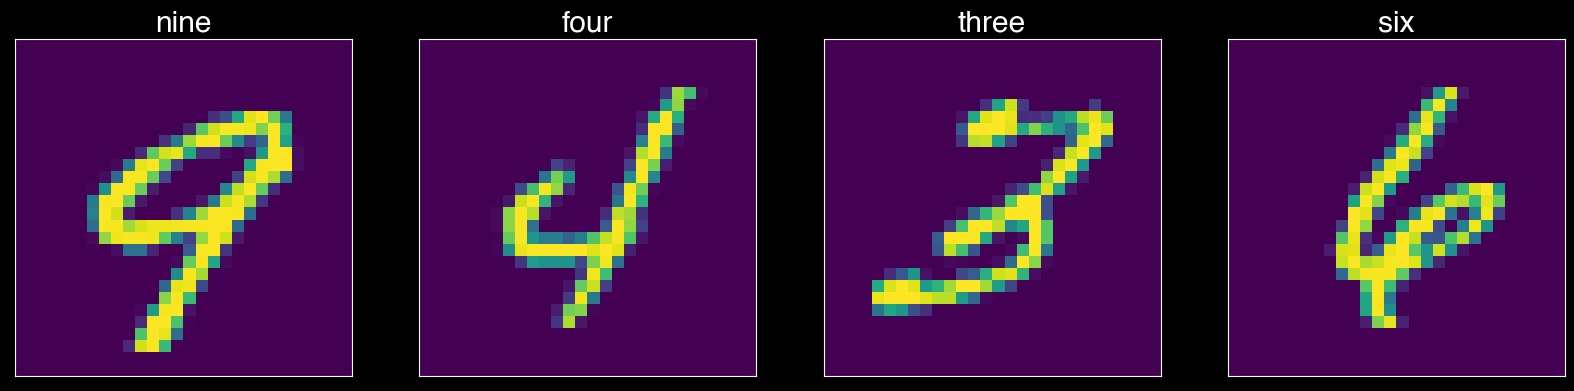

In [33]:
from cml.plot import cml_figure_matplotlib
test_size = 4
# Pick a random batch of input images
start_idx = np.random.randint(0, X_test.shape[0] - test_size)
x_batch = X_test[start_idx:start_idx+test_size]
# Perform inference on test data
predicted_probabilities = cnn(params, x_batch)
# Get predicted classes
predicted_classes = np.argmax(predicted_probabilities, axis=1)
# Define class names
class_names = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
# Get corresponding class names
class_labels = [class_names[i] for i in predicted_classes]
# Plot results
fig = cml_figure_matplotlib(100, 20); 
axs = fig.subplots(1, 4)
for i in range(test_size):
    axs[i].imshow(x_batch[i]); axs[i].set_title(class_labels[i]);
    axs[i].set_xticks([]); axs[i].set_yticks([]);

<a id="cnn"></a>
## Exercise 1 - Defining a CNN in Pytorch

Defining a convolutional network in Pytorch is quite easy, as we can rely on the `nn` module, which contains all the required layers

In [15]:
import torch
import torch.nn as nn

In the previous course, we have seen that we could define our network in a very simple way, by using the `Sequential` model definition. Here we define a CNN followed by a MLP, as seen in the previous course

In [16]:
# Define the input dimensions
in_size = 1000
# Use the nn package to define our model and loss function.
model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10),
    nn.Softmax(dim=1)
)
inputs = torch.rand(16, 3, 32, 32)
model(inputs);

Another way to implement the networks in Pytorch is to use the `functional` approach. In this version, each layer is seen as a function, that we apply on sucessive inputs. For instance, we can define one layer of fully-connected units and apply it to some inputs as follows.


In [17]:
import torch.nn.functional as F
# Define one layer
layer = nn.Linear(100, 10)
# Define the non-linearity
activation = nn.Sigmoid()
# Create some random input
inputs = torch.rand(32, 100)
# inputs.view(16, -1) => 200
# inputs.view(16, -1, 4) => 50
# Apply our layers
outputs = activation(layer(inputs))
# Equivalently, as ReLU is parameter-free
outputs = F.relu(layer(inputs))
y = (outputs + 3).sum()
y.backward()

Now to make this even cleaner, we can define our own `nn.Module`, which is a `Pytorch` class representing models. To do so, we can define a sub-class, and implement the functions `__init__` (defining our layers) and `forward` (explaining how our forward pass will behave)

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.1 - Implement a CNN by **using the `functional` library**

> 1. Update the forward propagation and error computation
> 2. Update the back-propagation part to learn the weights of both layers.
  
*For optional questions, please look at the end of this exercise's code boxes for more information*

</div>

***

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        ######################
        # YOUR CODE GOES HERE
        ######################

    def forward(self, x):
        
        ######################
        # YOUR CODE GOES HERE
        ######################
        
        return x

model = CNN()

### Training the network

In order to test our CNN, we are going to try to perform image classification. To do so, we can use the simplifications for data loading contained in `torchvision`

In [19]:
import torchvision
import torchvision.transforms as transforms

The `torchvision` package provides pre-coded simplification to download and use the major image datasets, notably `MNIST` and `CIFAR`, which are the baseline datasets for testing image ML models. The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In the following code, we are going to load the `CIFAR10` _train_ and _test_ sets. **Note that this code will automatically download the dataset if you did not have it before, and place it in the `data` folder, so this might take a bit of time**

In [20]:
# Transforms to apply to the images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Import the train dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
# Import the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
# Classes in the CIFAR dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Using your knowledge from the previous course, you can now define an optimization problem, and implement the training loop for your model

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.2 - Training our `functional` CNN

> 1. Define a `criterion` and `optimizer`
> 2. Fill in the training loop to train your model
  
*For optional questions, please look at the end of this exercise's code boxes for more information*

</div>

***

In [21]:
import torch.optim as optim

######################
# YOUR CODE GOES HERE
######################

criterion = ...
optimizer = ...

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #410819; border-color: #cb2e47">

> **Warning on the training time**

> The CIFAR dataset that we are using is a very large one, and given that we are using a deep architecture, the full training of the model will take a prohibitive time on a CPU. We recommend that you either ensure that you use the GPU of your own computer or (if unavailable) try out your code on the Colab version with a GPU runtime.

</div>

***

In [ ]:
n_epochs = 100
# Training loop
for epoch in range(n_epochs):
    running_loss = 0.0
    # Go through all batches
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        ######################
        # YOUR CODE GOES HERE
        ######################
        
    #print(f'loss at epoch {epoch}: {running_loss}')

Now that your model is trained, you can test it by feeding some new (unseen) images and see if it is able to classify them correctly

<a id="layer"></a>
## Coding our own convolutional layer

Although `Pytorch` comes packed with pre-implemented layers, we can also very easily define our own layers. This will be useful when you start doing research and propose your own way of processing the information. A large advantage of `Pytorch` is that it performs _automatic gradient differentiation_, this means that we simply have to define how the `forward` pass will work, and `Pytorch` will automatically infer the backpropagation equations, without us having to go through any complicated differentiation

In the following, we are going to redefine the `Conv2d` layer, by computing the operation ourselves.


***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Going further (optional)
>   1. Complete the `forward` function to compute a convolution
>   2. Do the same for the pooling operation
>   3. Rewrite your previous Pytorch CNN using your own modules
>   2. Train this model on the MNIST dataset

</div>

***


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyConv2d(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(MyConv2d, self).__init__()
        self.kernel_size = (kernel_size, kernel_size)
        self.kernal_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weights = nn.Parameter(torch.Tensor(self.out_channels, self.n_channels, self.kernal_size_number))

    def forward(self, x):
        width = self.compute_width(x)
        height = self.compute_height(x)
        windows = self.compute_windows(x)
        
        ######################
        # YOUR CODE GOES HERE
        ######################

        return x  

    def compute_windows(self, x):
        windows = F.unfold(x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride)
        windows = windows.transpose(1, 2).contiguous().view(-1, x.shape[1], self.kernal_size_number)
        windows = windows.transpose(0, 1)
        return windows

    def compute_width(self, x):
        return ((x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1) // self.stride[0]) + 1

    def compute_height(self, x):
        return ((x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)// self.stride[1]) + 1

# Testing the code directly
conv = MyConv2d(3, 1, 3)
x = torch.randn(1, 3, 24, 24)
out = conv(x)

Now you can use your own `MyConv2d` layer, and use it in real-life scenarios. Hence, you need to first implement the pooling operation and then trying to change your previous model to use your own layer instead. 

In [23]:
######################
# YOUR CODE GOES HERE
######################

## Exercise 2 - Recurrent Neural Networks (RNN)

Recurrent neural networks (RNNs) are a family of models designed to process time series and sequential data, which perform remarkably in applications such as speech recognition or machine translation. The ability of RNNs to model correlations between successive computations through recurrent connection make them efficient for temporal problem as they provide a form of _memory_. 

To model structured sequential data, NNs can be augmented with recurrent loops, which allow to retain information across time steps. Considering a sequence $\mathbf{X}=\{\mathbf{x}_t\}$, dependencies between elements are managed by having a recurrent hidden state $\mathbf{h}_t$ at time $t$ in the network. The value of $\mathbf{h}_t$ at each time depends of the previous time and the input, as depicted in the following figure. 

<img src="images/02_rnn.png" align="center"/>

Formally, each hidden state is updated as

$$
\begin{equation}
\mathbf{h}_t = 
\begin{cases} 
\phi_{\mathbf{\mathbf{\theta}}}(\mathbf{x}_0) & \mbox{if } t=0 \\ 
\phi_{\mathbf{\mathbf{\theta}}}(\mathbf{h}_{t-1},\mathbf{x}_t), & \mbox{otherwise} 
\end{cases}
\label{eq:RNNhiddenupdate}
\end{equation}
$$ 

### Implementing a simple rnn

Here's a simple one-to-many vanilla recurrent neural network example in functional form. If we were to produce `h[t]`, we need some weight matrices, `h[t-1]`, `x[t]` and a non-linearity `tanh`.

$$
h_{t} = tanh(W_{hh}h_{t-1} + W_{xh}x_{t} + B_{h})
$$

Since this is a **one-to-many** network, we'd want to produce an output `y[t]` at every timestep, thus, we need another weight matrix that accepts a hidden state and project it to an output.

$$
y_{t} = W_{hy}h_{t} + B_{y}
$$

Now that we know how to use the `Functional` library of `Pytorch`, we are going to implement our own simple RNN layer as previously. This time, we do not provide the content of the `__init__` function, so think carefully of what parameters you will need and how you need to define them.


***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 2.1 - Defining a `functional` RNN

> 1. Complete the `__init__` function to instantiate all required parameters
> 2. Complete the `forward` function to compute the forward pass

  
*For optional questions, please look at the end of this exercise's code boxes for more information*

</div>

***


In [24]:
import torch.nn as nn
import torch.nn.functional as F

class RecurrentNetwork(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        """ Defines the required variables """
        super(RecurrentNetwork, self).__init__()
        
        ######################
        # YOUR CODE GOES HERE
        ######################

    
    def forward(self, x):
        """ Computes the forward pass """
        
        ######################
        # YOUR CODE GOES HERE
        ######################
        output = ...
        
        return output

We can then forward propagate our information inside our network

In [25]:
in_size = 4
input_vector = torch.ones(16, in_size)
simple_network = RecurrentNetwork(in_size, 10, 5)
# Notice that same input, but leads to different ouptut at every single time step.
print(simple_network(input_vector))
print(simple_network(input_vector))
print(simple_network(input_vector))

Ellipsis
Ellipsis
Ellipsis


As usual, `Pytorch` also comes packed with some pre-coded recurrent layers. You can go check the documentation to find how to use these.

# Music generation with LSTMs 

In this exercise, we will explore how to use LSTMs (Long Short-Term Memory) for symbolic music generation with the help of `PyTorch`. Music generation with LSTM is a challenging problem where the goal is to train a model to generate new pieces of music that are musically coherent and similar to a given input dataset. However, there are several challenges associated with this task, such as capturing the long-term dependencies and structures that exist in music, dealing with the high dimensionality and complexity of musical data, and balancing the need for creativity and novelty with the desire for consistency and coherence. In addition, there is the issue of evaluating the quality of generated music, which can be subjective and context-dependent. Despite these challenges, recent advancements in deep learning techniques and models such as LSTMs have shown promising results in generating high-quality music, and the field continues to be an active area of research and development.

We will provide here the blueprint for adressing this problem by using a "mid-level" approach. Compared to the previous problems, we will heavily rely on the pre-defined layers available in `Pytorch` and `JAX` (through the `Flax` library). However, we will still need to define the overall approach to solve this problem, notably for the data pre-processing, model and loss definition and the overall training loop. The major library we will be using is the `torch.nn` as follows 

In [26]:
import torch.nn as nn

## Dataset

Usually, symbolic music scores in computers come in the [MIDI format](https://en.wikipedia.org/wiki/MIDI). MIDI files contain information about the _pitch_, _timing_, and _duration_ of musical notes, as well as other metadata such as tempo and instrument type. However, these are events that only provide information at various time positions. Hence, to train an LSTM model, the MIDI data needs to be converted into a suitable format that can be used as input to the model. This involves several preprocessing steps, such as **quantization**, **encoding**, and **normalization**. 
- _Quantization_ involves dividing the MIDI data into fixed time intervals and mapping each note to the nearest quantized time step. 
- _Encoding_ involves converting the quantized MIDI data into a numerical representation, such as a one-hot encoding or a continuous representation using embeddings. 
- _Normalization_ involves scaling the encoded data to a fixed range to ensure that the LSTM can learn meaningful patterns and avoid saturation or vanishing gradients. 

Overall, preprocessing the MIDI data is a crucial step in preparing the data for deep learning with LSTMs and can have a significant impact on the quality of the generated music. However, as this is a quite complicated set of operations, we will rather rely on a dataset that has already been preprocessed and is one of the "golden standard" in symbolic music generation, the [JSB Chorales dataset](https://github.com/czhuang/JSB-Chorales-dataset)

**Note for other input data**
If you want to try out your network on other data, and learn how to implement your own data pre-processing methods, we recommend trying out the [Groove dataset](https://www.tensorflow.org/datasets/catalog/groove) from TFDS, which contains a large number of drum performances (as scores) in [MIDI format](https://en.wikipedia.org/wiki/MIDI).

### Loading the dataset

Thanks to the great work on the [JSB Chorales github](https://github.com/czhuang/JSB-Chorales-dataset), we just need to retrieve a pickled (zipped) array and import it to obtain a prepared dataset for music generation.

In [27]:
import pickle
import requests
from io import BytesIO
from cml.plot import image, center_plot, cml_figure
# URL to load the JSB chorales dataset from
url = "https://github.com/czhuang/JSB-Chorales-dataset/raw/master/jsb-chorales-8th.pkl"
response = requests.get(url)
with open("./data/jsb_chorales.pkl", "wb") as f:
    f.write(response.content)
with open("./data/jsb_chorales.pkl", "rb") as p:
    data = pickle.load(p, encoding="latin1")

### Observing examples from the training set

A very important step before designing a model is to carefully scrutinize the properties of the data corresponding to the task we wish to address.

Here, each training example in the JSB Chorales dataset contains a sequence of 16th notes represented as integers, where each integer corresponds to a MIDI note number or a rest. The notes are represented using a simplified version where a note is represented as an integer in the range [0, 127], and a rest is represented as -1. The sequences represent the soprano, alto, tenor, and bass voices in four-part chorales from the J.S. Bach chorale harmonization collection. The chorales are all in 4/4 time, and each example consists of exactly 64 beats (i.e., 256 16th notes). 

The dataset contains a total of 229 chorales, split into 182 for training, 21 for validation, and 26 for testing. The dataset was created to facilitate research into automatic music composition and machine learning for music.

In [28]:
print(data["train"][0])

[(74, 70, 65, 58), (74, 70, 65, 58), (75, 70, 58, 55), (75, 70, 60, 55), (77, 69, 62, 50), (77, 69, 62, 50), (77, 70, 62, 55), (77, 69, 62, 55), (75, 67, 63, 48), (75, 69, 63, 48), (74, 70, 65, 46), (74, 70, 65, 46), (72, 69, 65, 53), (72, 69, 65, 53), (72, 69, 65, 53), (72, 69, 65, 53), (74, 70, 65, 46), (74, 70, 65, 46), (75, 69, 63, 48), (75, 67, 63, 48), (77, 65, 62, 50), (77, 65, 60, 50), (74, 67, 58, 55), (74, 67, 58, 53), (72, 67, 58, 51), (72, 67, 58, 51), (72, 65, 57, 53), (72, 65, 57, 53), (70, 65, 62, 46), (70, 65, 62, 46), (70, 65, 62, 46), (70, 65, 62, 46), (72, 69, 65, 53), (72, 69, 65, 53), (74, 71, 53, 50), (74, 71, 53, 50), (75, 72, 55, 48), (75, 72, 55, 50), (75, 67, 60, 51), (75, 67, 60, 53), (74, 67, 60, 55), (74, 67, 57, 55), (74, 65, 59, 43), (72, 63, 59, 43), (72, 63, 55, 48), (72, 63, 55, 48), (72, 63, 55, 48), (72, 63, 55, 48), (75, 67, 60, 60), (75, 67, 60, 60), (77, 70, 62, 58), (77, 70, 62, 56), (79, 70, 62, 55), (79, 70, 62, 53), (79, 70, 63, 51), (79, 70, 

Hence, based on the observed data, we can start thinking on how we could design an adequate model for processing this data. As we know that this form of data is clearly temporal, we will rely on network composed of LSTM cells. We can cast this task as an _inference_ problem, in which we try to **predict from a given sequence of notes the most probable next note**. Note that this allows us to straightforwardly use our trained network to generate entirely novel pieces of music, we just need to give different starting sequences, and then predict each note one by one (we feed the network with its own results from the past steps).

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Exercice (optional)
>   1. Create a model that can train on the proposed input data from JSB Chorales
>   2. Use at least one LSTM layer and an output layer for _prediction_
>   3. Write the training function for your model
>   4. Complete the training loop and launch your model

</div>

***

### Create the Model

In this step, you will implement an RNN or LSTM model using PyTorch. Design the architecture of your choice, but make sure it has at least one LSTM layer and an output layer with a softmax activation function.

In [103]:
class MusicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(MusicRNN, self).__init__()
        
        ######################
        # YOUR CODE GOES HERE
        ######################

    def forward(self, x):
        
        ######################
        # YOUR CODE GOES HERE
        ######################
        
        return out

### Training the Model

Now that our model is defined, we can train it on our preprocessed music data. Implement the training function using the appropriate loss function and optimizer.

In [104]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
   
    ######################
    # YOUR CODE GOES HERE
    ######################

Here you can define the final training loop for your music generation network

In [ ]:
# Create model, dataloader, optimizer and loss function
input_size = 1
hidden_size = 512
output_size = len(note_to_int)
num_layers = 1
batch_size = 64
# Try to use a GPU if we have one available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

######################
# YOUR CODE GOES HERE
######################

# Create our model
model = ...
# Create our optimizer and criterion
optimizer = ...
criterion = ...

# Train the model
num_epochs = 50

for epoch in range(num_epochs):
    
    ######################
    # YOUR CODE GOES HERE
    ######################

### Music Generation
With our trained model, we can now generate new music sequences. Implement a function that takes an initial sequence as input and generates a new sequence of notes and chords

In [34]:
def generate_music(model, initial_sequence, length, device):
    model.eval()
    generated_sequence = []

    for _ in range(length):
    
        ######################
        # YOUR CODE GOES HERE
        ######################
        pass

    return generated_sequence

### Listening to the results

In order to be able to listen to the beautiful results of your music generation LSTM, we provide here a code that is able to synthesize audio from a MIDI file so that you can directly hear your results :)

**Note that we apply this to an example from the training data, you need to change the following code so that it uses your `generate_music` function instead**

In [55]:
import music21
import random
# Select a random training example
example = random.choice(data['train'])

######################
# YOUR CODE GOES HERE
######################

# Convert the example notes to a music21 stream
stream = music21.stream.Stream()
print("Preparing stream")
for i, voice in enumerate(('soprano', 'alto', 'tenor', 'bass')):
    part = music21.stream.Part(id=voice)
    for note_f in example:
        note = note_f[i]
        if note == -1:  # Rest
            n = music21.note.Rest()
        else:  # Note
            n = music21.note.Note(note)
        part.append(n)
    stream.append(part)
# Play the music21 stream
print("Opening player")
sp = music21.midi.realtime.StreamPlayer(stream)
# Launch playing
print("Launching play (may take a while)")
sp.play()

Preparing stream
Opening player
Launching play (may take a while)
